In [1]:
%run ../input/python-recipes/cmap_header.py
%cmap_header Code Modules & Settings

In [2]:
import tensorflow as tf,tensorflow_hub as th
import time,tempfile,numpy as np,pylab as pl
from PIL import Image,\
ImageColor,ImageDraw,ImageFont,ImageOps
from six.moves.urllib.request import urlopen
from six import BytesIO
file_path='https://olgabelitskaya.gitlab.io/images/'
img_size=512
font_url='/usr/share/fonts/truetype/'+\
         'liberation/LiberationSansNarrow-Regular.ttf'
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%cmap_header Helpful Functions

In [4]:
def display_img(img):
    fig=pl.figure(figsize=(14,8))
    pl.grid(False); pl.imshow(img); pl.show()
def load_img(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    return img
def get_resize_img(file_name,file_path,
                   width=img_size,height=img_size,display=False):
    file_name=file_path+file_name
    img_data=urlopen(file_name).read()
    img_data=BytesIO(img_data)
    pil_img=Image.open(img_data)
    pil_img=ImageOps.fit(pil_img,(width,height),Image.ANTIALIAS)
    pil_img_rgb=pil_img.convert('RGB')
    _,file_img=tempfile.mkstemp(suffix='.jpg')
    pil_img_rgb.save(file_img,format='JPEG',quality=120)
    print('image file => %s'%file_img)
    if display: display_img(pil_img)
    return file_img

In [5]:
def bounding_box2img(img,ymin,xmin,ymax,xmax,
                     color,font,thickness=5,str_list=()):
    draw=ImageDraw.Draw(img)
    width,height=img.size
    left,right,top,bottom=\
    xmin*width,xmax*width,ymin*height,ymax*height
    draw.line([(left,top),(left,bottom),(right,bottom),
               (right,top),(left,top)],
              width=thickness,fill=color)
    str_heights=[font.getsize(el)[1] for el in str_list]
    total_str_height=1.1*sum(str_heights)
    if top>total_str_height:
        text_bottom=top
    else:
        text_bottom=top+total_str_height
    for el in str_list[::-1]:
        text_width,text_height=font.getsize(el)
        margin=np.ceil(.075*text_height)
        draw.rectangle([(left,text_bottom-text_height-2*margin),
                        (left+text_width,text_bottom)],fill=color)
        draw.text((left+margin,text_bottom-text_height-margin),
                  el,fill='black',font=font)
        text_bottom-=text_height-2*margin

In [6]:
def draw_boxes(img,boxes,class_names,scores,
               max_boxes=10,min_score=.1,font_url=font_url):
    colors=list(ImageColor.colormap.values())
    try:
        font=ImageFont.truetype(font_url,25)
    except IOError:
        print('this font does not found')
        font=ImageFont.load_default()
    for i in range(min(boxes.shape[0],max_boxes)):
        if scores[i]>=min_score:
            ymin,xmin,ymax,xmax=tuple(boxes[i])
            display_str='{}: {}%'.format(
                class_names[i].decode('ascii'),int(100*scores[i]))
            color=colors[hash(class_names[i])%len(colors)]
            img_pil=Image.fromarray(np.uint8(img)).convert('RGB')
            bounding_box2img(img_pil,ymin,xmin,ymax,xmax,
                             color,font,str_list=[display_str])
            np.copyto(img,np.array(img_pil))
    return img

In [7]:
%cmap_header Image Examples

image file => /tmp/tmpv5nf_8qx.jpg


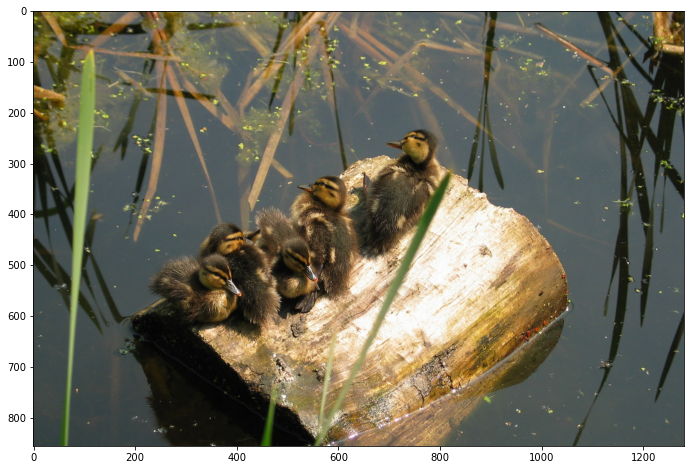

In [8]:
file_name1='01_023.png'
img_path1=get_resize_img(
    file_name1,file_path,width=1280,height=856,display=True)

image file => /tmp/tmpn27tvvwy.jpg


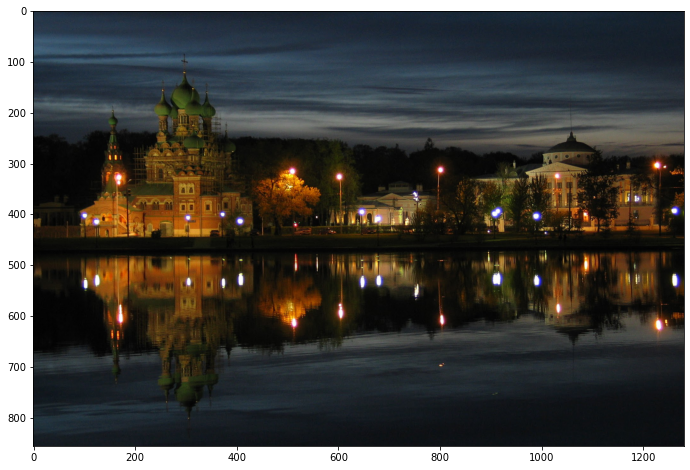

In [9]:
file_name2='01_026.png'
img_path2=get_resize_img(
    file_name2,file_path,width=1280,height=856,display=True)

In [10]:
%cmap_header TF Detector

In [11]:
def run_detector(detector,img_path):
    img=load_img(img_path)
    converted_img=tf.image.convert_image_dtype(
        img,tf.float32)[tf.newaxis,...]
    start_time=time.time()
    result=detector(converted_img)
    end_time=time.time()
    result={key:value.numpy() for key,value in result.items()}
    print('this detector has found %d objects'%\
          len(result['detection_scores']))
    print('inference time: ',end_time-start_time)
    img_with_boxes=draw_boxes(img.numpy(),result['detection_boxes'],
                              result['detection_class_entities'],
                              result['detection_scores'])
    display_img(img_with_boxes)

In [12]:
module_handle1='https://tfhub.dev/google/faster_rcnn/'+\
               'openimages_v4/inception_resnet_v2/1'
module_handle2='https://tfhub.dev/google/openimages_v4/ssd/'+\
               'mobilenet_v2/1' 
detector1=th.load(module_handle1).signatures['default']
detector2=th.load(module_handle2).signatures['default']

In [13]:
%cmap_header Object Detection

this detector has found 100 objects
inference time:  38.57588338851929


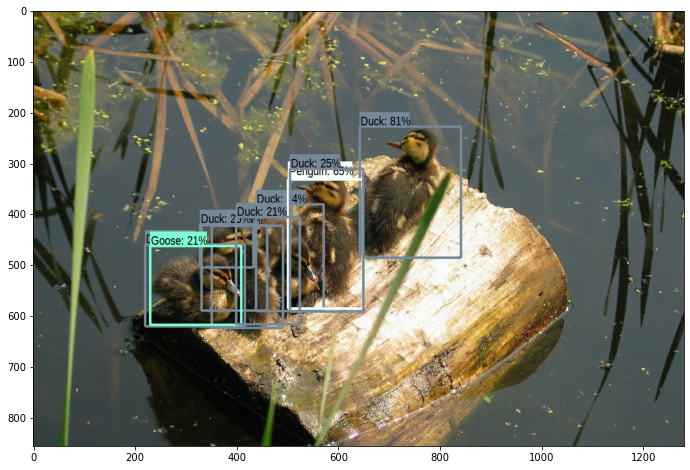

In [14]:
run_detector(detector1,img_path1)

this detector has found 100 objects
inference time:  5.720642566680908


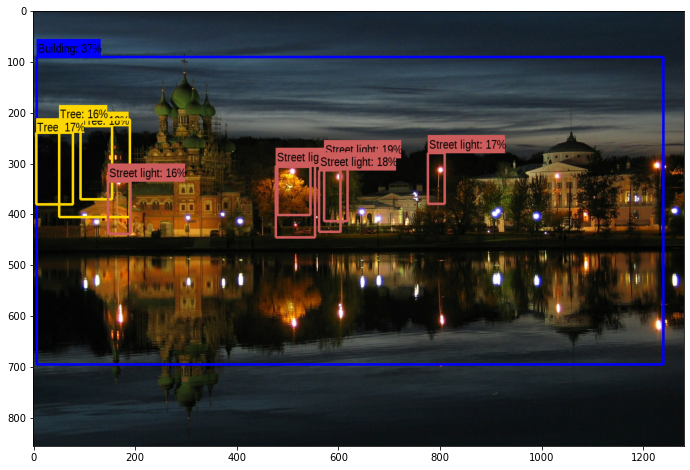

In [15]:
run_detector(detector2,img_path2)